In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import fastai.basics as fai
import fastai.vision as fv
from pathlib import Path
from shutil import copyfile
import random
import torch
import torch.nn.functional as F
import torch.nn as nn
import torchvision.utils as utils
import PIL
from PIL import Image, ImageDraw, ImageFont
from tqdm import tqdm_notebook as tqdm
import gc
import matplotlib.pyplot as plt
import numpy as np

In [3]:
path_good   = Path("StyleGAN/images1024x1024/")
path_crappy = Path("StyleGAN/crappy")

In [4]:
def load_data(img_size, batch_size, amount=1.):
    tfms = fv.get_transforms(max_zoom=1.1,max_warp=0.1)
    data = (fv.ImageImageList.from_folder(path_crappy)
            .filter_by_rand(amount)
            .random_split_by_pct(0.1)
            .label_from_func(lambda x: path_good/x.relative_to(path_crappy))
            .transform(tfms, size=img_size, tfm_y=True)
            .databunch(bs=batch_size)
            .normalize(fv.imagenet_stats, do_y=True))
    data.c = 3
    return data

In [6]:
def l1_loss_flat(a,b):
    return F.l1_loss(a.squeeze(), b.squeeze())

In [7]:
def create_learner(data):
    return fv.unet_learner(data, fv.models.resnet34, blur=True, norm_type=fai.NormType.Weight, self_attention=True, y_range=(-3.,3.), loss_func=l1_loss_flat, wd=1e-2)


In [5]:
data = load_data(256, 2, 0.1)

In [8]:
learn = create_learner(data)

In [9]:
iteration = 'A'
def save_model(img_size, num):
    path = Path(f'CrappyFaces/models/{iteration}')
    path.mkdir(exist_ok=True)
    torch.save(learn.model.state_dict(), path/f'{img_size}-{num}.pth')
def load_model(img_size, num):
    learn.model.load_state_dict(torch.load(f'CrappyFaces/models/{iteration}/{img_size}-{num}.pth'))

In [10]:
def show_tensor_as_image(tensor, ncols=5, figsize=12, title = ""):
    plt.figure(figsize=(figsize,figsize))
    plt.axis("off")
    plt.title(title)
    plt.imshow(np.transpose(utils.make_grid(tensor.detach().cpu()[:ncols*ncols], nrow=ncols, padding=2, normalize=True).cpu(),(1,2,0)))

def compare_manually():
    data = load_data(384,4,amount=0.01)
    gc.collect()
    imgs,targs = next(iter(data.valid_dl))
    learn.model.eval();
    gen_imgs = learn.model(imgs)
    show_tensor_as_image(imgs, ncols=1)
    show_tensor_as_image(gen_imgs, ncols=1)
    show_tensor_as_image(targs, ncols=1)

In [ ]:
learn.lr_find(); learn.recorder.plot()

In [ ]:
gc.collect()

In [ ]:
learn.fit_one_cycle(1,1e-3)

In [ ]:
learn.show_results(rows=3)

In [ ]:
save_model(128, "bah")

In [ ]:
sizes = [160, 192, 224, 256]
AS = {160:0.15, 192:0.2, 224:0.2, 256:0.3}
BS = {160:32, 192:24, 224:16, 256:8}

for size in sizes:
    lr = 2e-4
    for freeze in range(1, len(learn.layer_groups)+1):
        learn.data = load_data(size, BS[size], AS[size])
        learn.freeze_to(-freeze)
        print(f"{size} at freeze level {freeze}")
        gc.collect()
        torch.cuda.empty_cache()
        learn.fit_one_cycle(1, max_lr=slice(lr/64,lr),pct_start=0.7)
        save_model(size,freeze) 
        lr *= 0.8

In [ ]:
learn.show_results(rows=4)

# Perceptual loss

In [11]:
import sys
sys.path.append('PerceptualSimilarity')
sys.path.append('PerceptualSimilarity/util')
import PerceptualSimilarity as ps

In [12]:
learn.loss_func = ps.PerceptualLoss()

Loading model from: /home/mraggi/sources/Coursev1/PerceptualSimilarity/weights/v0.1/vgg.pth


In [13]:
learn.data = load_data(256,8,0.001)

In [15]:
learn.load('256-perceptual-final');

In [ ]:
learn.lr_find(); learn.recorder.plot()

In [ ]:
sizes = [160, 192, 224, 256]
AS = {160:0.15, 192:0.2, 224:0.2, 256:0.3}
BS = {160:20, 192:12, 224:8, 256:4}

for size in sizes:
    lr = 1e-4
    for freeze in range(1, len(learn.layer_groups)+1):
        learn.data = load_data(size, BS[size], AS[size])
        learn.freeze_to(-freeze)
        print(f"{size} at freeze level {freeze}")
        gc.collect()
        torch.cuda.empty_cache()
        learn.fit_one_cycle(1, max_lr=slice(lr/64,lr),pct_start=0.7)
        save_model(size,f"perceptual-{freeze}") 
        lr *= 0.8

In [ ]:
learn.show_results(rows=4,figsize=(18,18))

In [ ]:
learn.save('256-perceptual-final')

## GANs

Ahora vamos a usar GANs para mejorar la calidad de la imagen y a ver si se ve menos creepy. Primero entrenaremos un discriminador ("critic" le llaman ahora), con las imágenes ya generadas por el learn pre-entrenado. 

In [16]:
import fastai.vision.gan as fgan

Primero tenemos que guardar las imágenes

In [ ]:
gen_images = Path("StyleGAN/generated")
gen_images.mkdir(exist_ok=True)

In [ ]:
learn.data = load_data(256,4)

In [ ]:
def save_preds(dl):
    i=0
    names = dl.dataset.items
    
    for b in tqdm(dl):
        preds = learn.pred_batch(batch=b, reconstruct=True)
        for o in preds:
            o.save(gen_images/names[i].name)
            i += 1

In [ ]:
save_preds(learn.data.train_dl)

Para no acabarnos la memoria y seguir en el mismo notebook, vamos a borrar todo por el momento (al cabo lo guardamos!)

In [ ]:
learn = None
gc.collect()

In [17]:
def load_data_crit(classes, img_size, bs, amount=1.):
    tfms = fv.get_transforms(max_zoom=1.1)
    data = (fv.ImageList.from_folder(Path("StyleGAN"),include=classes)
            .filter_by_rand(amount)
            .random_split_by_pct(0.1, seed=666)
            .label_from_folder(classes=classes)
            .transform(tfms, size=img_size)
            .databunch(bs=bs)
            .normalize(fv.imagenet_stats))
    data.c = 3
    return data

In [ ]:
data_crit = load_data_crit(["generated", 'images1024x1024'], img_size=256, bs=4, amount=0.1)

In [ ]:
data_crit.show_batch(rows=2, ds_type=fai.DatasetType.Train, imgsize=3)

In [ ]:
gc.collect(); torch.cuda.empty_cache()

In [18]:
def create_critic_learner(data, metrics):
    loss_critic = fgan.AdaptiveLoss(nn.BCEWithLogitsLoss())
    return fai.Learner(data, fgan.gan_critic(), metrics=metrics, loss_func=loss_critic, wd=1e-2)

In [41]:
learn_critic = create_critic_learner(data_crit, fgan.accuracy_thresh_expand)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


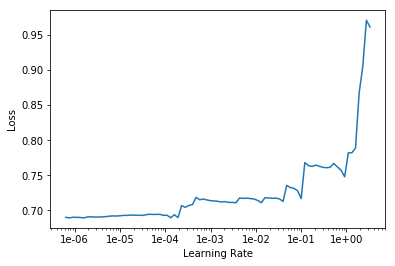

In [42]:
learn_critic.lr_find(); learn_critic.recorder.plot()

In [ ]:
learn_critic.fit_one_cycle(1, 1e-4)

epoch,train_loss,valid_loss,accuracy_thresh_expand,time


In [ ]:
learn_critic.data = get_crit_data(["generated", 'images1024x1024'], bs=8, img_size=256, amount=0.1)

In [ ]:
learn_critic.fit_one_cycle(1, 1e-3)

In [ ]:
learn_critic.save('critic-pretrain')

In [ ]:
learn_critic.data = get_crit_data(["generated", 'images1024x1024'], bs=8, img_size=256, amount=0.1)

In [ ]:
learn_critic.fit_one_cycle(1, 1e-3)

In [ ]:
learn_critic.data = get_crit_data(["generated", 'images1024x1024'], bs=8, img_size=256, amount=0.03)

In [ ]:
learn_critic.fit_one_cycle(1,1e-4)

In [ ]:
learn_critic.save('critic-pretrain')

# Combinar GAN con perceptual

In [39]:
learn_crit=None
learn_gen=None
gc.collect()

10261

In [48]:
gc.collect(); torch.cuda.empty_cache()

In [33]:
data_crit = load_data_crit(["generated", 'images1024x1024'], bs=4, img_size=256, amount=0.25)

In [34]:
data_gen = load_data(img_size=256,batch_size=4,amount=0.25)

In [35]:
learn_crit = create_critic_learner(data_crit, metrics=None).load('critic-pretrain')

In [36]:
learn_gen = create_learner(data_gen).load('256-perceptual-final')

In [37]:
switcher = fai.partial(fgan.AdaptiveGANSwitcher, critic_thresh=0.65, gen_thresh=0.8)
learn = fgan.GANLearner.from_learners(learn_gen, learn_crit, weights_gen=(1.,40.), show_img=True, switcher=switcher, opt_func=fai.partial(torch.optim.Adam, betas=(0.,0.99)), wd=1e-2)
learn.callback_fns.append(fai.partial(fgan.GANDiscriminativeLR, mult_lr=5.))

In [ ]:
learn.fit(5,1e-4)

epoch,train_loss,gen_loss,disc_loss,time


In [ ]:
learn_gen.data = load_data(img_size=256,batch_size=4,amount=0.5)
learn_crit.data = load_data_crit(["generated", 'images1024x1024'], bs=4, img_size=256, amount=0.5)

In [ ]:
learn.fit(10,1e-4)

In [ ]:
learn_gen.data = load_data(img_size=256,batch_size=4,amount=0.5)
learn_crit.data = load_data_crit(["generated", 'images1024x1024'], bs=4, img_size=256, amount=0.5)

In [ ]:
learn.fit(10,1e-5)

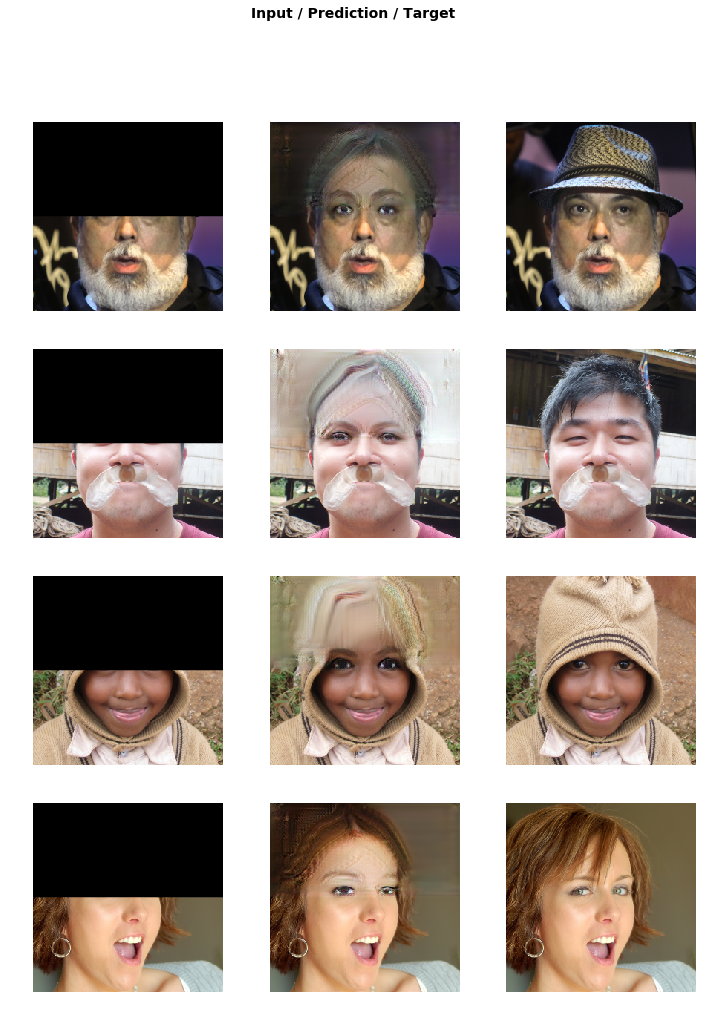

In [52]:
learn.show_results(rows=5)